In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
# HOME = '/workspace/'
sys.path.append(f'{HOME}/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/cddinterface/Pac\
kageInfo.g:85
    if not IsKernelExtensionAvailable("CddInterface") then
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/crypting/Package\
Info.g:82
   if not IsKernelExtensionAvailable("crypting") then
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/curlinterface/Pa\
ckageInfo.g:114
  if not IsKernelExtensionAvailable("curlinterface", "curl") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/cvec/PackageInfo\
.g:114
  if not IsKernelExtensionAvailable("cvec") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/datastruct

In [4]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

def get_models(model_dir):
    disable_progress_bars()
    local_dir = f'{HOME}/models/{model_dir}'
    if not os.path.exists(local_dir):
        snapshot_download(repo_id=f'wiwu2390/{model_dir}', local_dir=local_dir)
    models, params = load_models(local_dir, sel='final')
    models = models[0]
    data = GroupData(params)
    group = data.groups[0]
    return models, data, group

S5_MODEL_DIR = '2024-09-18_23-59-00_gapS5_MLP2_128_wd2e-4_ubias'
ISECT_MODEL_DIR = '2024-12-19_01-41-15_S5_A5x2_MLP2_128_ubias_wd2e-5'
S5_models, S5_data, group = get_models(S5_MODEL_DIR)
isect_models, isect_data, _ = get_models(ISECT_MODEL_DIR)

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: gapS(5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)
Intersection size: 7920/14400 (0.55)
Added 7920 elements from intersection
Added 0 elements from group 0: S(5)
Added 0 elements from group 1: times(A(5), Z(2))
Train set size: 7920/14400 (0.55)


Intersection size: 336/576 (0.58)
Added 336 elements from intersection
Added 0 elements from group 0: S(4)
Added 0 elements from group 1: times(A(4), Z(2))
Train set size: 336/576 (0.58)


/home/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


In [5]:
len(isect_data.train_data), len(S5_data.train_data)

(7920, 5760)

In [60]:
from sklearn.metrics.pairwise import pairwise_distances_chunked
from sklearn.linear_model import LinearRegression

# Copied from scikit-dimension package
# (Couldn't get the pip install to work)
def twonn(X, return_xy=False, discard_fraction=0.1, dist=False):
    """
    Calculates intrinsic dimension of the provided data points with the TWO-NN algorithm.

    -----------
    Parameters:

    X : 2d array-like
        2d data matrix. Samples on rows and features on columns.
    discard_fraction : float between 0 and 1
        Fraction of largest distances to discard (heuristic from the paper)
    dist : bool (default=False)
        Whether data is a precomputed distance matrix
    -----------
    Returns:

    d : float
        Intrinsic dimension of the dataset according to TWO-NN.
    -----------
    References:

    E. Facco, M. d’Errico, A. Rodriguez & A. Laio
    Estimating the intrinsic dimension of datasets by a minimal neighborhood information (https://doi.org/10.1038/s41598-017-11873-y)
    """

    N = len(X)

    if dist:
        r1, r2 = X[:, 0], X[:, 1]
        _mu = r2 / r1
        # discard the largest distances
        mu = _mu[np.argsort(_mu)[: int(N * (1 - discard_fraction))]]

    else:
        # mu = r2/r1 for each data point
        # relatively high dimensional data, use distance matrix generator
        # if X.shape[1] > 25:
        distmat_chunks = pairwise_distances_chunked(X)
        _mu = np.zeros((len(X)))
        i = 0
        for x in distmat_chunks:
            x = np.sort(x, axis=1)
            r1, r2 = x[:, 1], x[:, 2]
            _mu[i : i + len(x)] = r2 / r1
            i += len(x)

        # discard the largest distances
        mu = _mu[np.argsort(_mu)[: int(N * (1 - discard_fraction))]]

        # else:  # relatively low dimensional data, search nearest neighbors directly
        #     dists, _ = get_nn(X, k=2)
        #     r1, r2 = dists[:, 0], dists[:, 1]
        #     _mu = r2 / r1
        #     # discard the largest distances
        #     mu = _mu[np.argsort(_mu)[: int(N * (1 - discard_fraction))]]

    # Empirical cumulate
    Femp = np.arange(int(N * (1 - discard_fraction))) / N

    # Fit line
    lr = LinearRegression(fit_intercept=False)
    lr.fit(np.log(mu).reshape(-1, 1), -np.log(1 - Femp).reshape(-1, 1))

    d = lr.coef_[0][0]  # extract slope

    if return_xy:
        return d, np.log(mu).reshape(-1, 1), -np.log(1 - Femp).reshape(-1, 1)
    else:
        return d

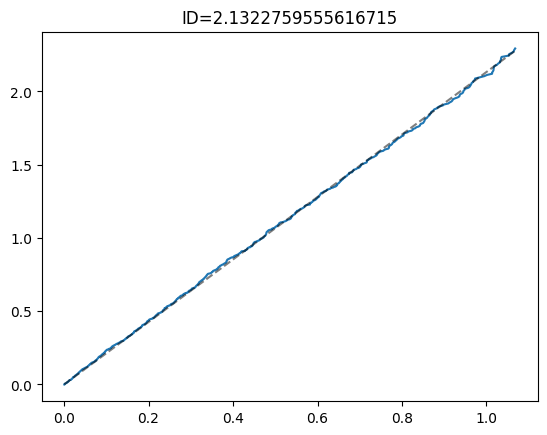

In [75]:
from sklearn.datasets import make_swiss_roll
X = make_swiss_roll(n_samples=1000, noise=0.1)[0]
d, x, y = twonn(X, return_xy=True)
plt.plot(x, y)
plt.plot(x, d * x, 'k', linestyle='--', alpha=0.5)
plt.title(f'ID={d}')
plt.show()

In [19]:
def get_preactivations(model, data):
    lneurons, rneurons, _ = model.get_neurons(squeeze=True)
    a1 = F.one_hot(data[:, 0], num_classes=model.N).float()
    a2 = F.one_hot(data[:, 1], num_classes=model.N).float()
    x1 = einops.einsum(
        a1,
        lneurons,
        "batch_size d_vocab, d_vocab embed_dim -> batch_size embed_dim",
    )
    x2 = einops.einsum(
        a2,
        rneurons,
        "batch_size d_vocab, d_vocab embed_dim -> batch_size embed_dim",
    )
    return x1, x2

In [20]:
def get_id(model, data):
    x1, x2 = get_preactivations(model, data)
    return twonn((x1 + x2).cpu().detach().numpy())

In [39]:
S5_train_data = t.tensor(S5_data.train_data).to(device)
isect_train_data = t.tensor(isect_data.train_data).to(device)

S5_idims = []
isect_idims = []

for i in tqdm(range(len(S5_models))):
    model = S5_models[i]
    S5_idims.append(get_id(model, S5_train_data))
    
for i in tqdm(range(len(isect_models))):
    model = isect_models[i]
    isect_idims.append(get_id(model, isect_train_data))

  0%|          | 0/100 [00:00<?, ?it/s]

> /tmp/ipykernel_39730/233230810.py(34)twonn()
     32     import pdb; pdb.set_trace()
     33 
---> 34     if dist:
     35         r1, r2 = X[:, 0], X[:, 1]
     36         _mu = r2 / r1

(5760, 128)


  0%|          | 0/100 [00:12<?, ?it/s]


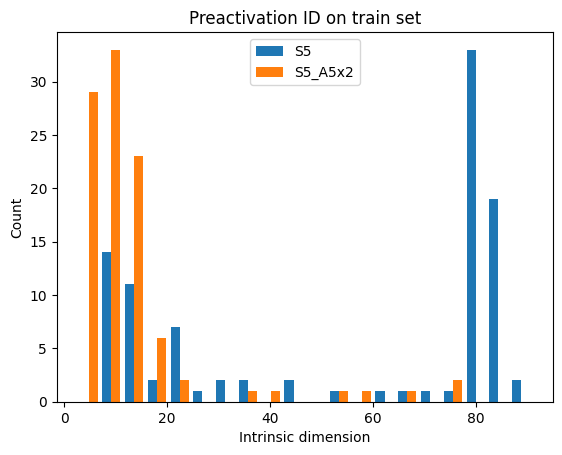

In [17]:
plt.hist([S5_idims, isect_idims], bins=20, label=['S5', 'S5_A5x2'], histtype='bar')
plt.title('Preactivation ID on train set')
plt.legend()
plt.xlabel('Intrinsic dimension')
plt.ylabel('Count')
plt.show()

In [23]:
test_data = t.tensor(list(product(range(S5_models.N), repeat=2)), device=device)
test_S5_idims = []
test_isect_idims = []

for i in tqdm(range(len(S5_models))):
    model = S5_models[i]
    test_S5_idims.append(get_id(model, test_data))
    
for i in tqdm(range(len(isect_models))):
    model = isect_models[i]
    test_isect_idims.append(get_id(model, test_data))

100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


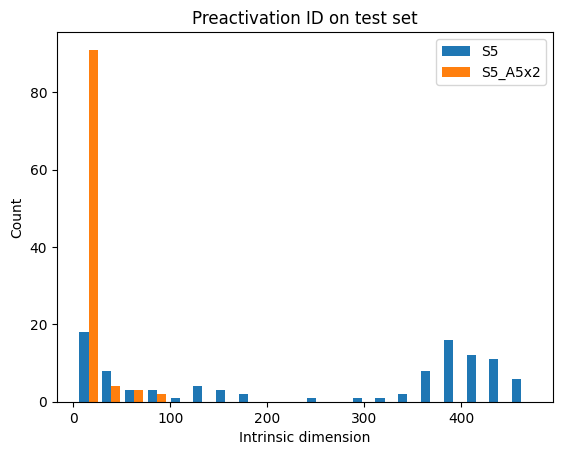

In [24]:
plt.hist([test_S5_idims, test_isect_idims], bins=20, label=['S5', 'S5_A5x2'], histtype='bar')
plt.title('Preactivation ID on test set')
plt.legend()
plt.xlabel('Intrinsic dimension')
plt.ylabel('Count')
plt.show()

In [66]:
S4_MODEL_DIR = '2024-12-20_19-12-16_S4_A4x2_MLP2_32_ubias_wd2e-5_BIG'
S4_models, S4_data, S4_group = get_models(S4_MODEL_DIR)

ACC_THRESH = 0.999
loss_dict = test_loss(S4_models.to(device), S4_data)
g0_grokked = (loss_dict['G0_acc'] > ACC_THRESH)
g1_grokked = (loss_dict['G1_acc'] > ACC_THRESH)
grokked = g0_grokked | g1_grokked
print('G0 grokked', g0_grokked.sum())
print('G1 grokked', g1_grokked.sum())
g0_models = S4_models[g0_grokked.nonzero().flatten()]
g1_models = S4_models[g1_grokked.nonzero().flatten()]
none_models = S4_models[(~(g0_grokked | g1_grokked)).nonzero().flatten()]

/home/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


Intersection size: 336/576 (0.58)
Added 336 elements from intersection
Added 0 elements from group 0: S(4)
Added 0 elements from group 1: times(A(4), Z(2))
Train set size: 336/576 (0.58)
G0 grokked tensor(603)
G1 grokked tensor(43)


In [67]:
train_data = t.tensor(S4_data.train_data, device=device)
g0_id_train = [get_id(g0_models[i], train_data) for i in tqdm(range(40))]
g1_id_train = [get_id(g1_models[i], train_data) for i in tqdm(range(40))]
none_id_train = [get_id(none_models[i], train_data) for i in tqdm(range(40))]

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:03<00:00, 10.92it/s]


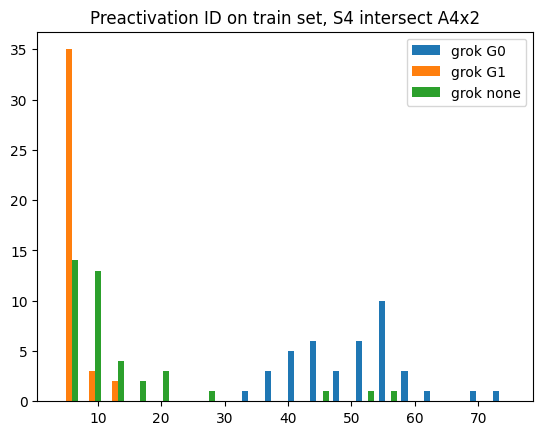

In [68]:
plt.hist([g0_id_train, g1_id_train, none_id_train], bins=20, label=['grok G0', 'grok G1', 'grok none'], histtype='bar')
plt.legend()
plt.title('Preactivation ID on train set, S4 intersect A4x2')
plt.show()

In [36]:
test_data = t.tensor(list(product(range(S4_models.N), repeat=2)), device=device)
g0_id_test = [get_id(g0_models[i], test_data) for i in tqdm(range(40))]
g1_id_test = [get_id(g1_models[i], test_data) for i in tqdm(range(40))]
none_id_test = [get_id(none_models[i], test_data) for i in tqdm(range(40))]

100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


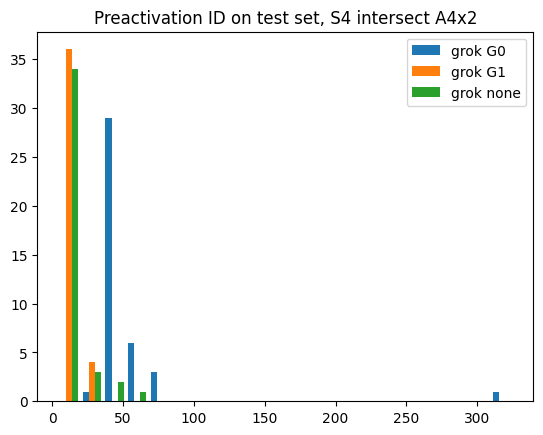

In [37]:
plt.hist([g0_id_test, g1_id_test, none_id_test], bins=20, label=['grok G0', 'grok G1', 'grok none'], histtype='bar')
plt.legend()
plt.title('Preactivation ID on test set, S4 intersect A4x2')
plt.show()

Text(0.5, 1.0, 'ID=55.354518235876014')

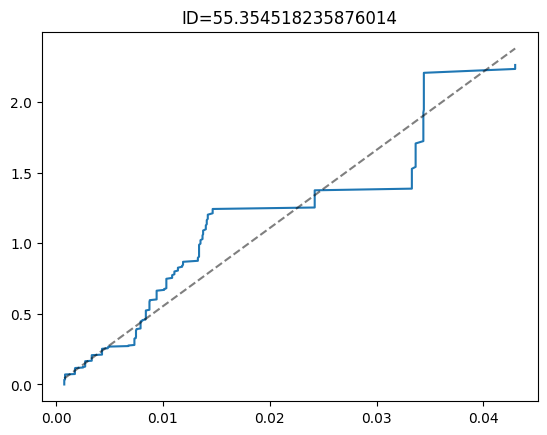

In [74]:
x1, x2 = get_preactivations(g0_models[0], train_data)
X = x1 + x2
d, x, y = twonn(X.cpu().detach().numpy(), return_xy=True)
plt.plot(x, y)
plt.plot(x, d * x, 'k', linestyle='--', alpha=0.5)
plt.title(f'ID={d}')